# SETUP

In [2]:
import pandas as pd
import numpy as np

from causalAssembly.models_dag import ProductionLineGraph
from causalAssembly.drf_fitting import fit_drf

from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG

from castle.algorithms import Notears
from dagma.linear import DagmaLinear
from castle.algorithms import GAE
from castle.algorithms import DirectLiNGAM
from castle.algorithms import PC


import torch
import time
import csv

import networkx as nx
import matplotlib.pyplot as plt

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-09 11:51:34,539 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-07-09 11:51:34,600 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [4]:
def plot_graph_adjacency_matrix(ground_truth, save_name):

    # create figure
    fig, (ax1, ax2) = plt.subplots(figsize=(15, 8), ncols=2)

    # subplot for graph
    ax1.set_title('Graph', y= 1.05, fontsize=20)
    G = nx.from_numpy_matrix(ground_truth, create_using=nx.DiGraph)
    nx.draw(G, ax=ax1, with_labels=True)

    # subplot for heatmap
    ax2.set_title('Adjazenzmatrix Heat Map', y= 1.05, fontsize = 20)
    map1 = ax2.imshow(ground_truth, cmap='Greys', interpolation='none')
    cbar = fig.colorbar(map1, ax=ax2)
    cbar.ax.set_position([cbar.ax.get_position().x0, ax2.get_position().y0,
                        cbar.ax.get_position().width, ax2.get_position().height])


    # Ensure subplots have same height and position in y direction
    ax1_height = ax2.get_position().height
    ax1.set_position([ax1.get_position().x0, ax2.get_position().y0,
                    ax1.get_position().width, ax1_height])
    ax2.set_position([ax2.get_position().x0, ax2.get_position().y0,
                    ax2.get_position().width, ax1_height])

    # save
    plt.savefig(save_name)
    plt.show()

# CREATE GRAPH

requirements:

3-cell production process

cell_1: 34-40 characteristics (boolean), resembling the vehicle characteristics (originally 670, but correlation analysis limited this to 25 relevant ones)

cell_2: 2 characteristics: mean ergonomics and duration. Both are contiunous, but could be binned.
    idea: get continuous data for each and then bin it into 4 bins

cell_3: 1 charactreristic: defect (boolean)

only forward-reaching connections possible from cell i to i+1


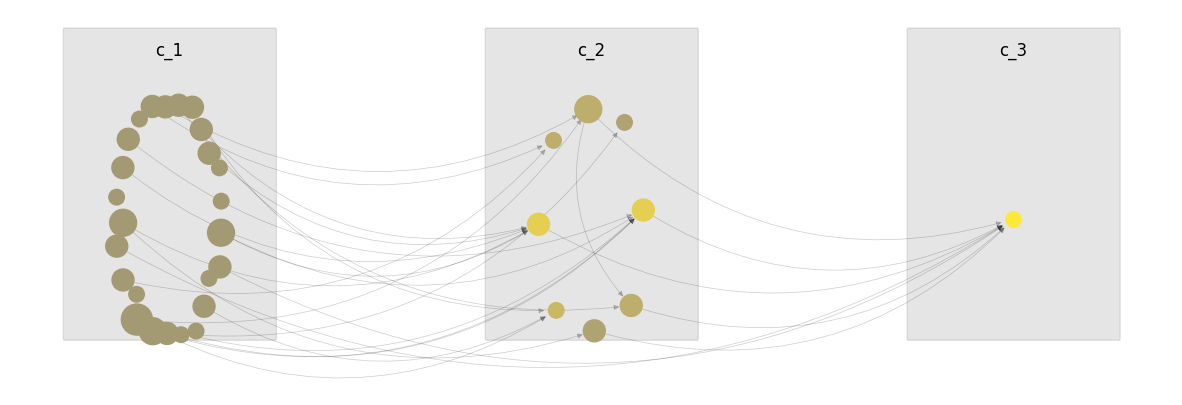

In [3]:
### CREATE GRAPH

custom_line5 = ProductionLineGraph()

n_characteristics = 25
n_bins_ergo = 4
n_bins_dur = 4

## CELL_1

custom_line5.new_cell(name='c_1')
custom_line5.c_1.add_random_module(n_nodes=n_characteristics, p=0)

## CELL_2

custom_line5.new_cell(name='c_2')
# mean ergonomics
custom_line5.c_2.add_random_module(n_nodes=n_bins_ergo)
# mean duration
custom_line5.c_2.add_random_module(n_nodes=n_bins_dur)

## CELL_3

custom_line5.new_cell(name='c_3')
custom_line5.c_3.add_random_module(n_nodes=1)



### CREATE CONNECTIONS

# connections with default values
custom_line5.connect_cells(forward_probs=[0.1, 0.05])

# adjusted for more connections from cell2 to cell3
edges = []

# create semi random connections
import random
random.seed(40)

probs = []

for node in range (1, n_bins_ergo+n_bins_dur+1):
    probs.append(random.randint(1,100)/100)


# create connection of prob > 0.5
for node in range(0, n_bins_ergo):
    if probs[node] > 0.5:
        edges.append((f'c_2_M1_{node}', 'c_3_M1_0')) # M1 for ergo module

for node in range(0, n_bins_dur):
    if probs[node + n_bins_ergo] > 0.5:
        edges.append((f'c_2_M2_{node}', 'c_3_M1_0')) # M2 for duration module

custom_line5.connect_across_cells_manually(edges) 


custom_line5.show(fig_size=(15,5))


save ground truth

In [7]:
custom_line5.ground_truth.to_csv('data/causalAssembly/custom_line5/custom_line5_ground_truth.csv', index=False)

plot ground truth

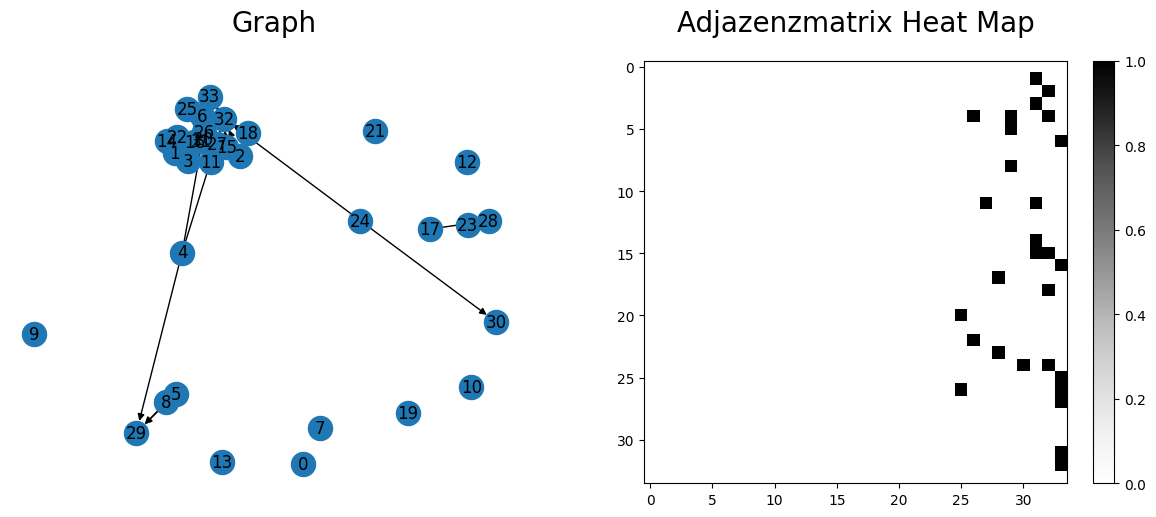

In [5]:
ground_truth = pd.read_csv('data/causalAssembly/custom_line5/custom_line5_ground_truth.csv').to_numpy()
save_name = 'plots/adj_matrix/causalAssembly/custom_line5/ground_truth.png'
plot_graph_adjacency_matrix(ground_truth, save_name)

create data

In [10]:
sample_sizes = [500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]

for sample_size in sample_sizes:
    IIDSimulation_data = IIDSimulation(W=ground_truth, n=sample_size, method='linear', sem_type='logistic')
    # save data to csv
    data = pd.DataFrame(IIDSimulation_data.X)
    data.to_csv(f'data/causalAssembly/custom_line5/custom_line5_data_{data.shape[0]}.csv', index=False)
    print(f"saved data for sample size {sample_size}")

2024-07-08 15:55:57,649 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-07-08 15:55:57,664 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-07-08 15:55:57,690 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-07-08 15:55:57,809 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


saved data for sample size 500
saved data for sample size 1000
saved data for sample size 2000


2024-07-08 15:55:58,010 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


saved data for sample size 5000


2024-07-08 15:55:58,329 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


saved data for sample size 10000


2024-07-08 15:55:58,898 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


saved data for sample size 20000
saved data for sample size 50000


2024-07-08 15:56:00,099 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


saved data for sample size 100000
